# SARIMA for 7243.KL

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

ticker = "7243.KL"
tdata = yf.Ticker(ticker)
df = tdata.history(period="max",end="2020-05-01")
df = df.filter(items=['Close'])

#Convert to Series
# df = df.squeeze()
df = df.resample('MS').mean().dropna()
df

,Close
Date,
2007-12-01,2.273247
2008-01-01,1.860955
2008-02-01,1.335694
2008-03-01,1.157865
2008-04-01,1.300668
...,...
2019-12-01,0.228571
2020-01-01,0.228571
2020-02-01,0.164000


Range to test on:
 2019-04-01 00:00:00 	 2020-04-01 00:00:00


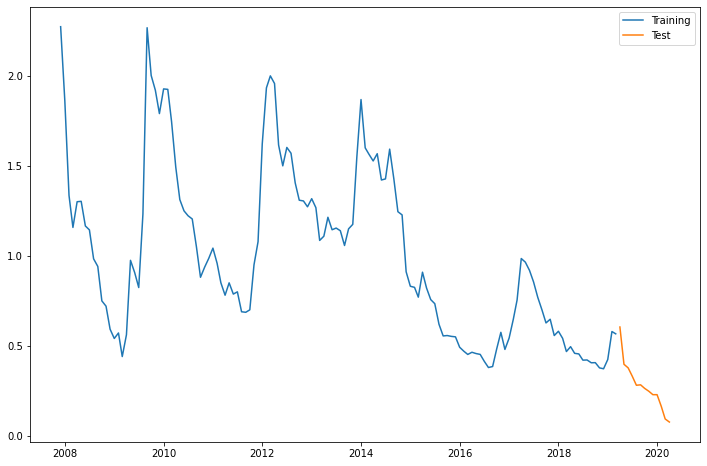

In [2]:
n = 13
train = df[:-n]
test = df[-n:]
print("Range to test on:\n",test.index[0],"\t",test.index[-1])
plt.figure(figsize=(12,8))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.legend()
plt.show()

## Selecting hyperparameters as well as training the model

In [3]:
import itertools

#Initializing arrays for optimal parameters for p,d,q and P,D,Q,m
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print(seasonal_pdq)
# print(pdq)

#Finding best combo with the lowest AIC
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)
        except: 
            continue

params = AIC_list.iloc[AIC_list['AIC'].idxmin()]

#Model fitting, note the use of the entire df for fitting
mod = sm.tsa.statespace.SARIMAX(df,
                                order=params.param,
                                seasonal_order=params.param_seasonal,
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print("### Min_AIC_list ### \n{}".format(params))

print(results.summary().tables[1])

### Min_AIC_list ### 
param                 (0, 1, 1)
param_seasonal    (0, 0, 0, 12)
AIC                    -135.598
Name: 24, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3108      0.042      7.335      0.000       0.228       0.394
sigma2         0.0244      0.001     18.588      0.000       0.022       0.027


In [4]:
start = test.index[0]
end = test.index[-1]

print(start,"\t",end)

2019-04-01 00:00:00 	 2020-04-01 00:00:00


## Forecasting the dataset as well as evaluating the trained model

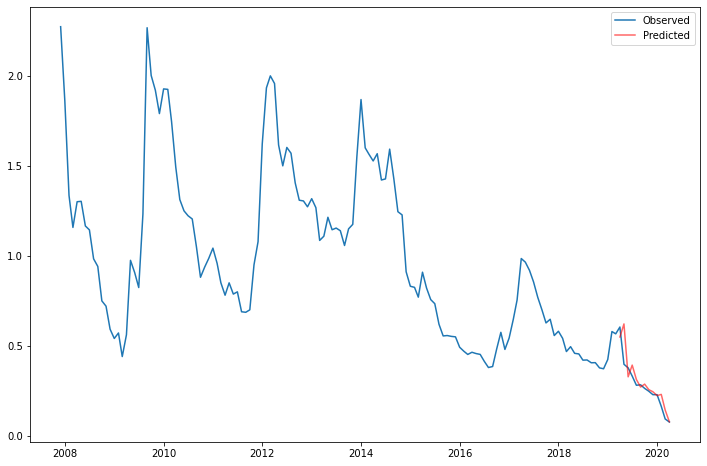

The MSE is: 0.005269762069368535


In [5]:
pred = results.predict(start=pd.to_datetime("2019-04-01"),end=pd.to_datetime("2020-04-01"),dynamic=False)
#plot prediction results
plt.figure(figsize=(12,8))
plt.plot(df,label="Observed")
plt.plot(pred,color="red",alpha=.6,label="Predicted")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
print("The MSE is: {}".format(mean_squared_error(test,pred)))

## Forecasting beyond the dataset

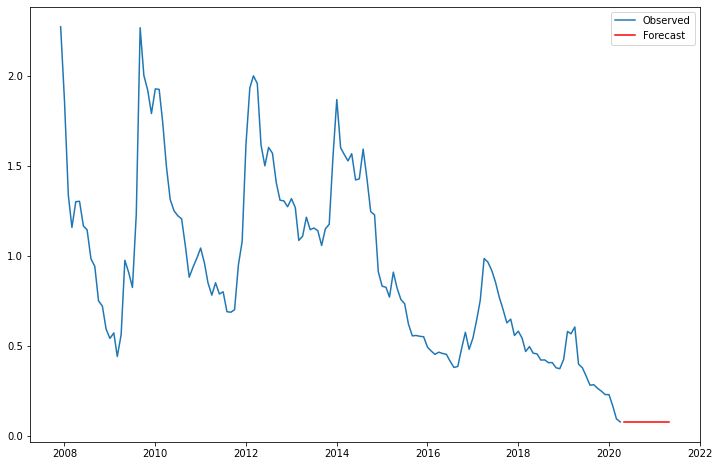

In [6]:
#Forecast
# dates = pd.date_range(start="2020-05-01",end="2021-05-01")
pred_uc = results.forecast(steps=13)

#Plot
plt.figure(figsize=(12,8))
plt.plot(df,label="Observed")
plt.plot(pred_uc,color='red',label="Forecast")
plt.legend()
plt.show()


In [7]:
#Forecasted values
pred_uc

2020-05-01    0.076104
2020-06-01    0.076104
2020-07-01    0.076104
2020-08-01    0.076104
2020-09-01    0.076104
2020-10-01    0.076104
2020-11-01    0.076104
2020-12-01    0.076104
2021-01-01    0.076104
2021-02-01    0.076104
2021-03-01    0.076104
2021-04-01    0.076104
2021-05-01    0.076104
Freq: MS, dtype: float64